In [1]:
# y-data-profiling
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Shivansh\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv("train.csv")

In [3]:
data['Heart Disease'].unique()

array(['Presence', 'Absence'], dtype=object)

In [4]:
data['Heart Disease'] = data['Heart Disease'].map({'Absence': 0, 'Presence': 1})

In [5]:
data.drop(columns=['id'],axis=1,inplace=True)

In [6]:
data['stress_score'] = (
    data['Exercise angina'].astype(int)
    + (data['ST depression'] > 1).astype(int)
    + (data['Slope of ST'] == 2).astype(int)
)

In [7]:
# data.drop(columns=['Exercise angina', 'ST depression', 'Slope of ST'], axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation Heatmap')

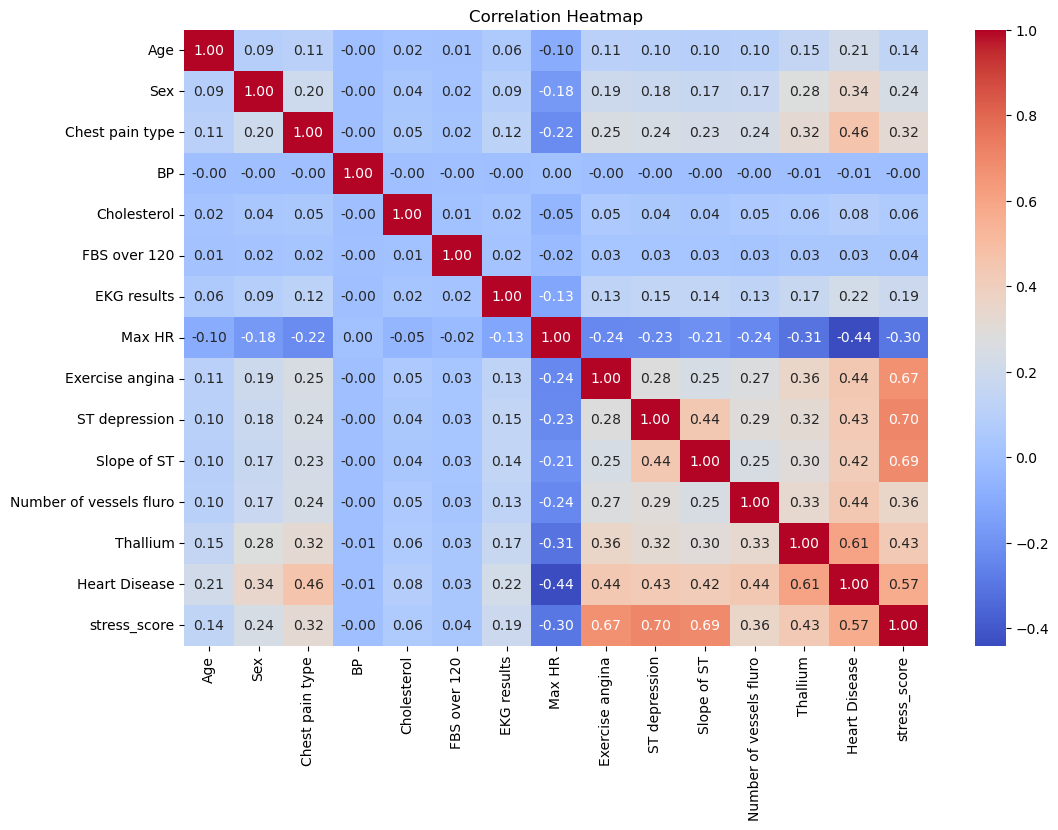

In [8]:
#heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")

In [9]:
data["bp_elevated"]     = ((data["BP"] >= 120) & (data["BP"] < 130)).astype(int)
data["bp_stage1_htn"]   = ((data["BP"] >= 130) & (data["BP"] < 140)).astype(int)
data["bp_stage2_htn"]   = (data["BP"] >= 140).astype(int)

# Age-adjusted BP
data["bp_age_ratio"] = data["BP"] / data["Age"]

# ---------- Cholesterol features ----------
data["chol_borderline"] = (data["Cholesterol"] >= 200).astype(int)
data["chol_high"]       = (data["Cholesterol"] >= 240).astype(int)

# Cholesterol interaction
data["chol_age"] = data["Cholesterol"] * data["Age"]

# ---------- FBS-based features ----------
# (FBS_over_120 assumed to be 0/1 already)

# Metabolic interaction
data["metabolic_risk"] = (
    (data["FBS over 120"] == 1) &
    (data["Cholesterol"] >= 200)
).astype(int)

# ---------- Composite risk score ----------
data["metabolic_risk_score"] = (
    (data["BP"] >= 140).astype(int) +
    (data["Cholesterol"] >= 240).astype(int) +
    (data["FBS over 120"] == 1).astype(int)
)

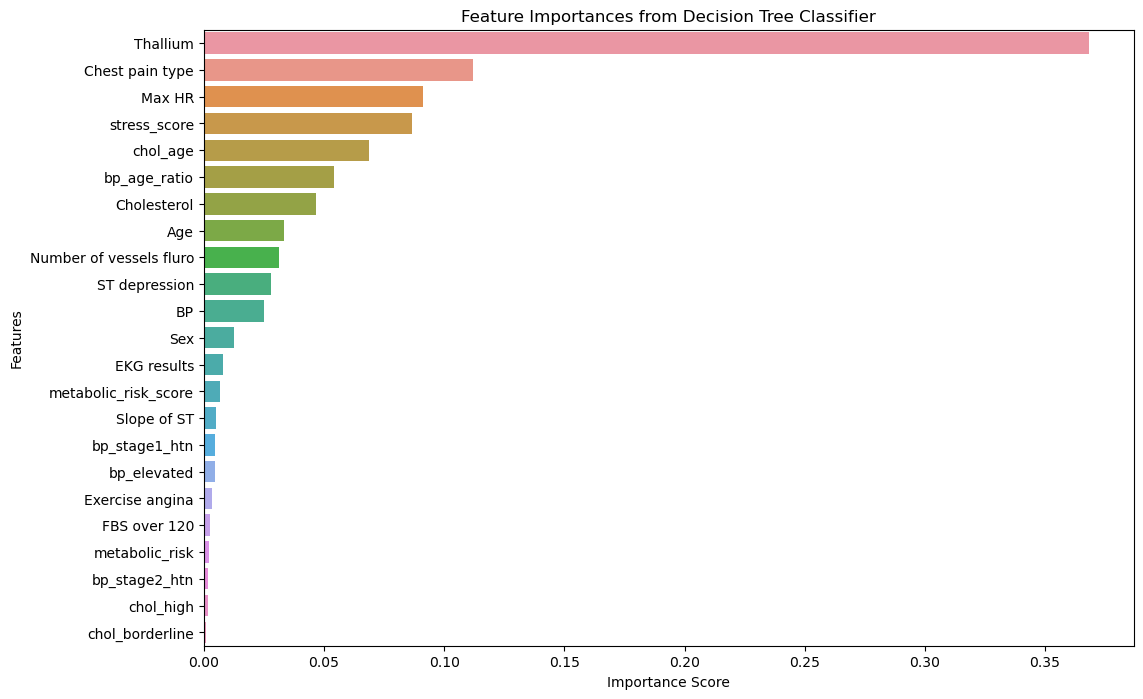

In [10]:
# build a decision tree model to evaluate feature importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X = data.drop(columns=['Heart Disease'])
y = data['Heart Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importances from Decision Tree Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

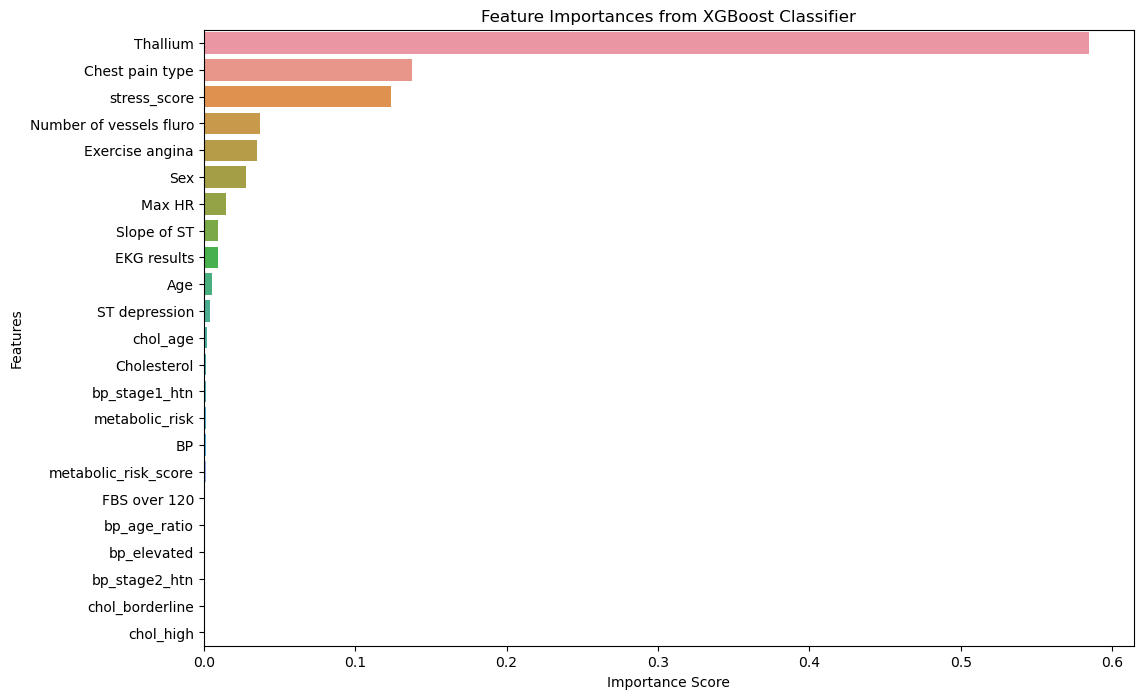

In [12]:
# build a xgboost model to evaluate feature importance
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_
xgb_feature_importances = pd.Series(xgb_importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=xgb_feature_importances, y=xgb_feature_importances.index)
plt.title("Feature Importances from XGBoost Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [14]:
# based on the feature importance plots, create a dataframe with both models' importance scores
importance_df = pd.DataFrame({
    'Decision_Tree_Importance': feature_importances,
    'XGBoost_Importance': xgb_feature_importances
})

importance_df.sort_values(by=['Decision_Tree_Importance', 'XGBoost_Importance'], ascending=False)

,Decision_Tree_Importance,XGBoost_Importance
Thallium,0.368477,0.584921
Chest pain type,0.111942,0.137617
Max HR,0.091250,0.014867
stress_score,0.086647,0.123501
chol_age,0.068939,0.002194
bp_age_ratio,0.053972,0.000963
Cholesterol,0.046603,0.001496
Age,0.033276,0.005637
Number of vessels fluro,0.031199,0.036883
ST depression,0.028135,0.003898


In [16]:
# take top 10 features from both models
top_tree_features = feature_importances.head(10).index.tolist()
top_boosting_features = xgb_feature_importances.head(10).index.tolist()

In [21]:
# now build a h2o automl using the selected features for tree and boosting models separately classification
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size="4G")
# Convert pandas dataframe to h2o frame
h2o_data = h2o.H2OFrame(data)
h2o_data['Heart Disease'] = h2o_data['Heart Disease'].asfactor()
# Split into train and test
train, test = h2o_data.split_frame(ratios=[0.8], seed=42)
# H2O AutoML with top tree features
aml_tree = H2OAutoML(max_runtime_secs=300, seed=42)
aml_tree.train(x=top_tree_features, y='Heart Disease', training_frame=train)
# H2O AutoML with top boosting features
aml_boosting = H2OAutoML(max_runtime_secs=300, seed=42)
aml_boosting.train(x=top_boosting_features, y='Heart Disease', training_frame=train)
# Evaluate performance
lb_tree = aml_tree.leaderboard
lb_boosting = aml_boosting.leaderboard
print("H2O AutoML with Top Tree Features Leaderboard:")
print(lb_tree)
print("H2O AutoML with Top Boosting Features Leaderboard:")
print(lb_boosting)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 16 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 7 days
H2O_cluster_name:,H2O_from_python_Shivansh_zf7atg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.909 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:09:53.292: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:16:00.37: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
H2O AutoML with Top Tree Features Leaderboard:
model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_1_AutoML_2_20260201_150953  0.949844   0.283831  0.942578                0.119111  0.293223  0.0859797
StackedEnsemble_AllModels_1_AutoML_2_20260201_150953     0.949844   0.283944  0.94264                 0.119098  0.29324   0.0859899
StackedEnsemble_BestOfFamily_2_AutoML_2_20260201_150953  0.949827   0.283971  0.942557                0.119165  0.293235  0.0859867
GBM_1_AutoML_2_

In [22]:
# from boosting features leaderboard select best model and evaluate on test set
best_model = aml_boosting.leader
preds = best_model.predict(test)
performance = best_model.model_performance(test)
print(performance)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.08453028303290071
RMSE: 0.29074092080906105
LogLoss: 0.27854528242868976
AUC: 0.9518254245944593
AUCPR: 0.9449327768547218
Gini: 0.9036508491889186
Null degrees of freedom: 125684
Residual degrees of freedom: 125682
Null deviance: 172823.71473060572
Residual deviance: 70017.92764409975
AIC: 70023.92764409975

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4474208696371097
       0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      61786  7716   0.111    (7716.0/69502.0)
1      6891   49292  0.1227   (6891.0/56183.0)
Total  68677  57008  0.1162   (14607.0/125685.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447421 

In [23]:
# predict on new data 
test_data = pd.read_csv("test.csv")

# prepare test data similar to training data
# (Assuming similar feature engineering steps as above)
test_data['stress_score'] = (
    test_data['Exercise angina'].astype(int)
    + (test_data['ST depression'] > 1).astype(int)
    + (test_data['Slope of ST'] == 2).astype(int)
)

test_data["bp_elevated"]     = ((test_data["BP"] >= 120) & (test_data["BP"] < 130)).astype(int)
test_data["bp_stage1_htn"]   = ((test_data["BP"] >= 130) & (test_data["BP"] < 140)).astype(int)
test_data["bp_stage2_htn"]   = (test_data["BP"] >= 140).astype(int)
test_data["bp_age_ratio"] = test_data["BP"] / test_data["Age"]
test_data["chol_borderline"] = (test_data["Cholesterol"] >= 200).astype(int)
test_data["chol_high"]       = (test_data["Cholesterol"] >= 240).astype(int)
test_data["chol_age"] = test_data["Cholesterol"] * test_data["Age"]
test_data["metabolic_risk"] = (
    (test_data["FBS over 120"] == 1) &
    (test_data["Cholesterol"] >= 200)
).astype(int)
test_data["metabolic_risk_score"] = (
    (test_data["BP"] >= 140).astype(int) +
    (test_data["Cholesterol"] >= 240).astype(int) +
    (test_data["FBS over 120"] == 1).astype(int)
)

# select features used in the best model
final_features = top_boosting_features  # assuming boosting features performed better
h2o_test_data = h2o.H2OFrame(test_data[final_features])
predictions = best_model.predict(h2o_test_data)
predictions_df = predictions.as_data_frame()
print(predictions_df)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\Shivansh\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


        predict        p0        p1
0             1  0.053839  0.946161
1             0  0.990380  0.009620
2             1  0.010803  0.989197
3             0  0.990717  0.009283
4             0  0.839189  0.160811
...         ...       ...       ...
269995        0  0.897712  0.102288
269996        0  0.614588  0.385412
269997        0  0.952484  0.047516
269998        0  0.871024  0.128976
269999        0  0.966806  0.033194

[270000 rows x 3 columns]


In [24]:
# create a submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'Heart Disease': predictions_df['predict']
})
submission.to_csv("submission.csv", index=False)